In [158]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, balanced_accuracy_score, confusion_matrix
import pymongo
import pandas as pd

mongohost = "192.168.0.246"
mongoport = 15213
collection = 'MLresults_resub'

# instantiate the mongo client
client = pymongo.MongoClient(mongohost, mongoport)
# get handle to database
db = client.ferret
plt.rcParams['svg.fonttype'] = 'none'


In [165]:
def getClassifierAccuracies(sub, classifierName, hmapBool=0,location = []):
    if location:
        matchDict = {"subject":sub,
                    "classifier": classifierName,
                    "feats":{"$nin":[7,8,'pca','all']},
                    "locs": location,}
    else:
        matchDict = {"subject":sub,
                    "classifier": classifierName,
                    "feats":{"$nin":[7,8,'pca','all']}}
            
    result = db.command({
            'aggregate': collection,
            'pipeline': [
                {'$match': matchDict},
                {"$project": {
                    "_id": 0,
                    "label": ["$subject","$states","$locs","$feats","$numObservations",],
                    "numFeats": {"$size": "$feats"},
                    "accuracy": {"$avg":"$accuracyList"},
                    "std": {"$stdDevSamp": "$accuracyList"},
#                     "accuracy_jumbled": {"$avg": "$accuracyList_jumbled"},
#                     "std_jumbled": {"$stdDevSamp": "$accuracyList"},
                }},
#                 {'$match': {"numFeats":{"$lte":4},}}, # "accuracy":{"$lte":0.85}
                {"$sort": {"accuracy":-1}}
            ]})
    return result['result']

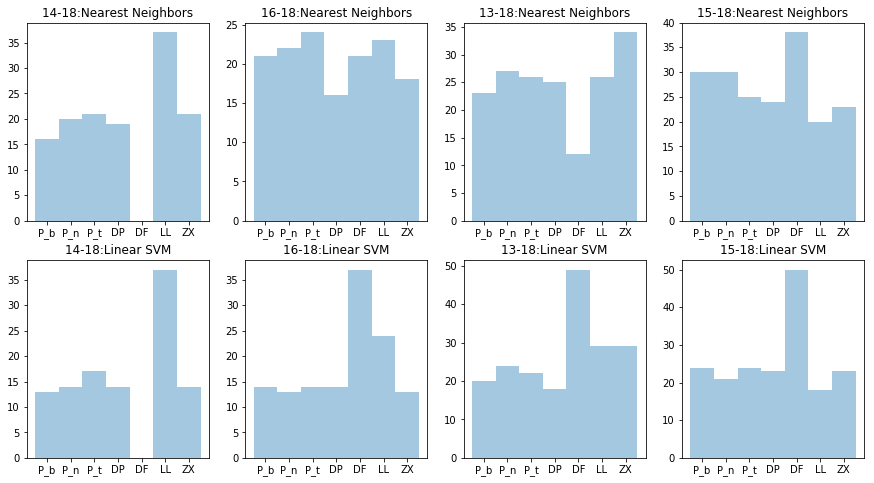

In [169]:
# names = ["Nearest Neighbors", "Linear SVM","Naive Bayes"]
# paddleOrder = ['S1','S2','S3','S4']\
# 1/2/3/4/5/6/7/8/9  => bradyPercent/normoPercent/tachyPercent/DP/DF/LL/A/E/ZX

f,ax = plt.subplots(2,4,figsize=(15,8))
for iSub, subj in enumerate(['14-18','16-18','13-18','15-18']):
    for idx, classifier  in  enumerate(["Nearest Neighbors", "Linear SVM"]):
        allObj = getClassifierAccuracies(subj,classifier)
        percentile90 = int(len(allObj)*0.1)
        
#         print percentile90
        featList = []
        for iObj in allObj[:percentile90]:
#             if iObj['accuracy'] > 0.8:
            featList.extend(iObj['label'][3])
        
        featListMod = [7 if x==9 else x for x in featList]

        sns.distplot(featListMod,bins =  [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], ax=ax[idx][iSub],kde=False)
        ax[idx][iSub].set_xticks([1,2,3,4,5,6,7])
        ax[idx][iSub].set(xticklabels=['P_b','P_n','P_t','DP','DF','LL','ZX'])
        ax[idx][iSub].title.set_text("%s:%s" %(subj,classifier))
        
# f.savefig('optimal_feats.svg')

[u'S2', u'S3', u'S4']
[u'S1', u'S3', u'S4']
[u'S1', u'S2', u'S3', u'S4']
[u'S1S1', u'S3S1', u'S4S1', u'S4S3']


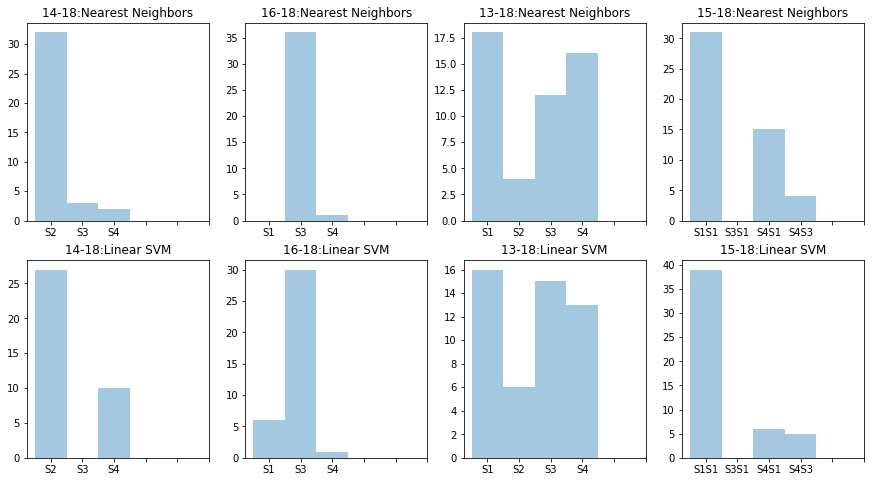

In [172]:
f,ax = plt.subplots(2,4,figsize=(15,8))
for iSub, subj in enumerate(['14-18','16-18','13-18','15-18']):
    paddleOrder = sorted(db[collection].find({'subject':subj}).distinct('locs'))
    print paddleOrder
    for idx, classifier  in  enumerate(["Nearest Neighbors", "Linear SVM"]):
        allObj = getClassifierAccuracies(subj,classifier)
        percentile90 = int(len(allObj)*0.1)
        
        locationList = []
        for iObj in allObj[:percentile90]:
#             if isinstance(iObj['label'],list):
#                 locationList.extend(iObj['label'][2])
#             else:
            locationList.append(iObj['label'][2])
                    
        
#         print locationList
        locationIdx = [paddleOrder.index(i) for i in locationList]
#         print locationList 
        sns.distplot(locationIdx, bins = [-0.5, 0.5, 1.5,2.5,3.5,4.5], ax=ax[idx][iSub],kde=False)
        ax[idx][iSub].title.set_text("%s:%s" %(subj,classifier))
        ax[idx][iSub].set_xticks([0,1,2,3,4,5])
        ax[idx][iSub].set(xticklabels=paddleOrder)

# f.savefig('optimal_segments.svg')

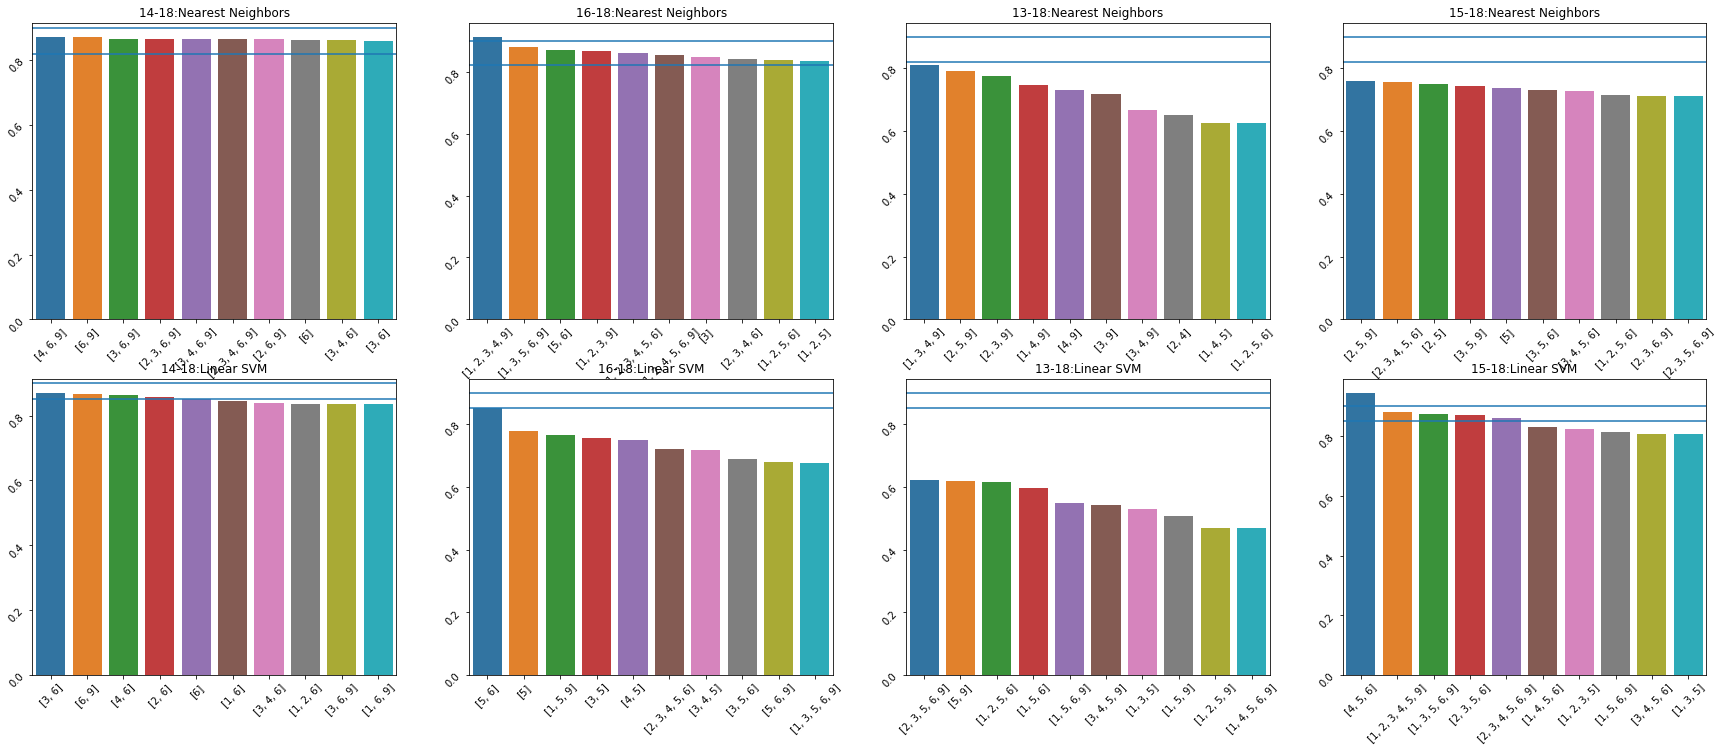

In [207]:
# names = ["Nearest Neighbors", "Linear SVM","Naive Bayes"]
# paddleOrder = ['S1','S2','S3','S4']\
# 1/2/3/4/5/6/7/8/9  => bradyPercent/normoPercent/tachyPercent/DP/DF/LL/A/E/ZX
masterFeatList = []
featList2 = []
acc = [0.82,0.85,0.82,0.81]
location =['S2','S3','S3','S1S1']
f,ax = plt.subplots(2,4,figsize=(30,12))
for iSub, subj in enumerate(['14-18','16-18','13-18','15-18']):
    for idx, classifier  in  enumerate(["Nearest Neighbors", "Linear SVM"]):
        allObj = getClassifierAccuracies(subj,classifier,location = location[iSub])
        percentile90 = 10 #int(len(allObj)*0.1)
        
#         print percentile90
        featList = []
        accuracyList = []
#        
        for iObj in allObj[:percentile90]:
#             if iObj['accuracy'] > 0.8:
            featList.append(str(iObj['label'][3]))
            featList2.append(iObj['label'][3])
            accuracyList.append(iObj['accuracy'])
        
        masterFeatList.extend(featList)
#         featListMod = [7 if x==9 else x for x in featList]

        sns.barplot(x=featList, y =accuracyList, ax=ax[idx][iSub])
#         ax[idx][iSub].set_xticks([1,2,3,4,5,6,7])
#         ax[idx][iSub].set(xticklabels=['P_b','P_n','P_t','DP','DF','LL','ZX'])
        ax[idx][iSub].title.set_text("%s:%s" %(subj,classifier))
        ax[idx][iSub].tick_params(labelrotation=45)
        ax[idx][iSub].axhline(y=acc[idx], xmin=0, xmax=1)
        ax[idx][iSub].axhline(y=0.9, xmin=0, xmax=1)
        
# f.savefig('optimal_feats.svg')

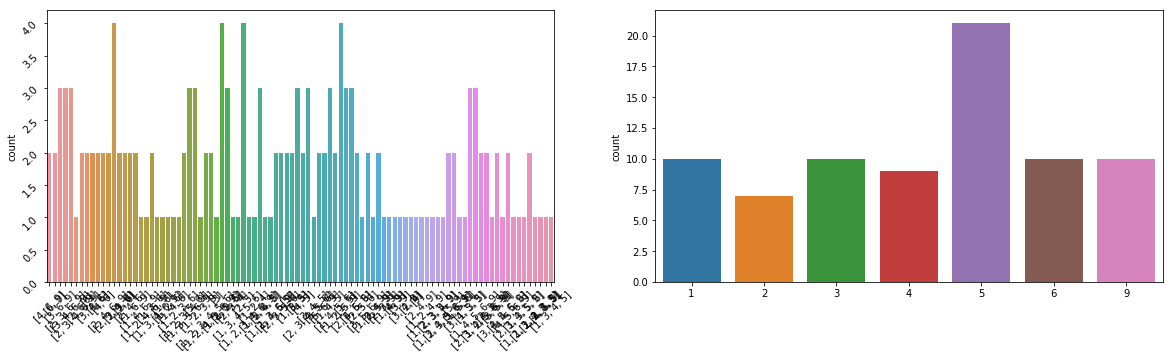

In [201]:
# print masterFeatList
tmp = [str(x) for x in masterFeatList]
f,ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(tmp,ax=ax[0])
ax[0].tick_params(labelrotation=45)

# print featList2
asd = sum(featList2,[])
sns.countplot(asd,ax=ax[1])
ax[0].tick_params(labelrotation=45)

In [206]:
featList2

[[4, 5, 6],
 [1, 2, 3, 4, 5, 9],
 [1, 3, 5, 6, 9],
 [2, 3, 5, 6],
 [2, 3, 4, 5, 6, 9],
 [1, 4, 5, 6],
 [1, 2, 3, 5],
 [1, 5, 6, 9],
 [3, 4, 5, 6],
 [1, 3, 5]]